<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 Dengue cases in Singapore by eweeks modelling/ prediction


In this script, we attempt to fit a Regression model to predict the number of dengue cases (y variable) depending on the various x variables ( 

##  Read in Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import statsmodels.api as sm

from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\gohch\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_excel('data/Output after Merged.xlsx')

In [3]:
df.head()


,epi_week_year,start,dengue_cases,Year,Month,Day,total_rainfall,rainfall_30min,rainfall_60min,rainfall_120min,...,temperature_max,temperature_min,windspeed_mean,windspeed_max,Date,Epiweek,Town,Region,freq_dengue_gtrends,freq_wolbachia_gtrends
0,2013-W21,19/5/2013,0,2013,5,19,52.8,4.218408,5.170072,5.854992,...,34.9,22.7,4.100000,38.9,19/5/2013,2013-W21,ang mo kio,Central,114.186851,0.0
1,2013-W22,26/5/2013,0,2013,5,26,56.2,4.218408,5.170072,5.854992,...,34.3,23.0,4.371429,64.8,26/5/2013,2013-W22,ang mo kio,Central,530.153238,0.0
2,2013-W23,2/6/2013,23,2013,6,2,123.8,3.740979,4.576394,5.233173,...,35.5,23.2,4.357143,48.2,2/6/2013,2013-W23,ang mo kio,Central,424.122590,0.0
3,2013-W24,9/6/2013,23,2013,6,9,8.8,3.740979,4.576394,5.233173,...,34.1,24.2,6.328571,39.2,9/6/2013,2013-W24,ang mo kio,Central,815.620366,0.0
4,2013-W25,16/6/2013,11,2013,6,16,1.0,3.740979,4.576394,5.233173,...,34.6,26.8,6.300000,43.9,16/6/2013,2013-W25,ang mo kio,Central,530.153238,0.0


In [4]:
#Convert 'Month' into a categorical variable
df['Month'] = df['Month'].apply(lambda x:str(x)) 

In [5]:
df.dtypes

epi_week_year              object
start                      object
dengue_cases                int64
Year                        int64
Month                      object
Day                         int64
total_rainfall            float64
rainfall_30min            float64
rainfall_60min            float64
rainfall_120min           float64
temperature_mean          float64
temperature_max           float64
temperature_min           float64
windspeed_mean            float64
windspeed_max             float64
Date                       object
Epiweek                    object
Town                       object
Region                     object
freq_dengue_gtrends       float64
freq_wolbachia_gtrends    float64
dtype: object

At this point, we wish to do some EDA on the individual Towns in df so that we see if there are any 

Since 'Town' and 'Region' are perfectly correlated, we want to choose 1 to be in the model and one-hot encoded as dummies, while the other one should be dropped. We also drop the variables 'epi_week_year', 'start' (start date of week), 'Date' and 'Year' as they denote time variables which are not important in a model that is not time series modelling (ARIMA)

In [6]:
df_sub = df.drop(columns = ['epi_week_year','start','Date','Epiweek','Town','Year'])
df_dummies = pd.get_dummies(df_sub, drop_first=True)

In [7]:
df_dummies.dtypes

dengue_cases                int64
Day                         int64
total_rainfall            float64
rainfall_30min            float64
rainfall_60min            float64
rainfall_120min           float64
temperature_mean          float64
temperature_max           float64
temperature_min           float64
windspeed_mean            float64
windspeed_max             float64
freq_dengue_gtrends       float64
freq_wolbachia_gtrends    float64
Month_10                    uint8
Month_11                    uint8
Month_12                    uint8
Month_2                     uint8
Month_3                     uint8
Month_4                     uint8
Month_5                     uint8
Month_6                     uint8
Month_7                     uint8
Month_8                     uint8
Month_9                     uint8
Region_East                 uint8
Region_North                uint8
Region_North East           uint8
Region_South                uint8
Region_West                 uint8
dtype: object

In [8]:
#df_dummies['dengue_cases_log'] = np.log1p(df_dummies['dengue_cases'])
#df_dummies.drop(columns=['dengue_cases'], inplace = True)

In [9]:
df_dummies.shape

(9494, 29)

Train-Test Split

In [11]:
y = df_dummies['dengue_cases']
X = df_dummies.drop(columns = 'dengue_cases', axis = 1, inplace = False, errors = 'raise')

In [20]:
print(y.shape)
print(X.shape)
print(X.dtypes)

(9494,)
(9494, 28)
Day                         int64
total_rainfall            float64
rainfall_30min            float64
rainfall_60min            float64
rainfall_120min           float64
temperature_mean          float64
temperature_max           float64
temperature_min           float64
windspeed_mean            float64
windspeed_max             float64
freq_dengue_gtrends       float64
freq_wolbachia_gtrends    float64
Month_10                    uint8
Month_11                    uint8
Month_12                    uint8
Month_2                     uint8
Month_3                     uint8
Month_4                     uint8
Month_5                     uint8
Month_6                     uint8
Month_7                     uint8
Month_8                     uint8
Month_9                     uint8
Region_East                 uint8
Region_North                uint8
Region_North East           uint8
Region_South                uint8
Region_West                 uint8
dtype: object


In [21]:
# Split the data into the training and testing sets for normal tokenized words
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [22]:
ss = StandardScaler()
rs = RobustScaler()
Xs_train = ss.fit_transform(X_train)
Xr_train = rs.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)
Xr_test = rs.fit_transform(X_test)

In [23]:
lr = LinearRegression()

lr.fit(X_train, y_train)

#lr.score(X_test, y_test) #cannot score as we are not given y_test

lr_scores = cross_val_score(lr, X_train, y_train, cv= 5) #Use scaled Xs instead of X_train

print (lr_scores)
print (np.mean(lr_scores)) 

[0.14958856 0.1432256  0.10699498 0.13049505 0.15134838]
0.136330515147919


In [106]:
lr2 = LinearRegression()

lr2.fit(Xs, y_train)

lr2_scores = cross_val_score(lr2, Xs, y_train, cv= 5) #Use scaled Xs instead of X_train

print (lr2_scores)
print(lr2.score(X_test, y_test) )
print (np.mean(lr_scores)) 

[0.14958856 0.1432256  0.10699498 0.13049505 0.15134838]
-533.3777031682488
0.057332085117190366


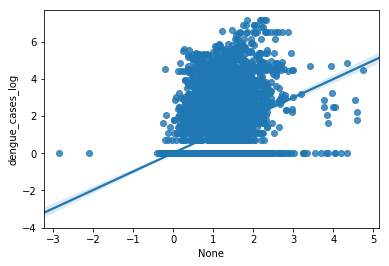

In [24]:
model_sm = sm.OLS(y_train, X_train).fit()
sns.regplot(model_sm.predict(X_train),y_train)

In [ ]:
model_sm = sm.OLS(y_train, X_train).fit()
sns.regplot(model_sm.predict(X_train),y_train)

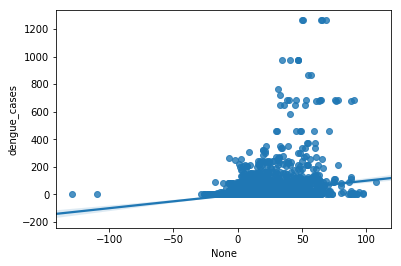

In [96]:
model_sm = sm.OLS(y_train, X_train).fit()
sns.regplot(model_sm.predict(X_train),y_train)

We can see from this graph that the relationship between number of dengue cases and its regressors are highly not linear. Most weekly dengue cases do not exceed 400, while there are a handful that exceed above that threshold. Hence the linear regression model is limited at predicting number of dengue cases

In [73]:
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           dengue_cases   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     31.65
Date:                Fri, 13 Jan 2023   Prob (F-statistic):          4.61e-158
Time:                        22:16:05   Log-Likelihood:                -39900.
No. Observations:                7120   AIC:                         7.986e+04
Df Residuals:                    7092   BIC:                         8.005e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Day                       -0.0519      0.089     -0.582      0.560      -0.227       0.123
total_rainfall             0.0270      0.018      1.515      0.130      -0.008       0.062
rainfall_30min            -0.1642      0.324     -0.507      0.612      -0.798       0.470
rainfall_60min             0.2576      0.422      0.611      0.541      -0.569       1.084
rainfall_120min            0.0908      0.247      0.368      0.713      -0.393       0.575
temperature_mean          -7.8892      1.602     -4.924      0.000     -11.030      -4.748
temperature_max            2.8421      0.923      3.079      0.002       1.033       4.651
temperature_min            5.3217      0.915      5.815      0.000       3.528       7.116
windspeed_mean             1.9998      0.437      4.575      0.000       1.143       2.857
windspeed_max             -0.0752      0.109     -0.691      0.490      -0.289       0.138
freq_dengue_gtrends        0.1106      0.012      8.991      0.000       0.087       0.135
freq_wolbachia_gtrends     0.1388      0.036      3.843      0.000       0.068       0.210
Month_10                   5.3675      3.900      1.376      0.169      -2.277      13.012
Month_11                   1.8458      3.943      0.468      0.640      -5.883       9.574
Month_12                   1.6922      3.728      0.454      0.650      -5.616       9.000
Month_2                   -0.8231      4.006     -0.205      0.837      -8.676       7.030
Month_3                    0.6937      3.949      0.176      0.861      -7.048       8.436
Month_4                    1.9343      4.011      0.482      0.630      -5.929       9.797
Month_5                    3.5276      3.996      0.883      0.377      -4.306      11.361
Month_6                   10.6462      3.978      2.676      0.007       2.848      18.445
Month_7                   27.7841      3.914      7.099      0.000      20.112      35.456
Month_8                   23.7297      3.838      6.183      0.000      16.206      31.254
Month_9                   16.2409      3.945      4.117      0.000       8.507      23.974
Region_East              -13.2573      3.400     -3.899      0.000     -19.923      -6.592
Region_North             -32.0354      3.545     -9.036      0.000     -38.985     -25.085
Region_North East        -23.7938      3.575     -6.656      0.000     -30.801     -16.786
Region_South             -32.2797      3.565     -9.054      0.000     -39.268     -25.291
Region_West              -29.9195      3.050     -9.811      0.000     -35.898     -23.941
==============================================================================
Omnibus:                    11135.014   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5722463.626
Skew:                    

The R squared and adjusted R squared which show the goodness of fit of the model is quite low at 0.1.
For metrics, we evaluate the accuracy and RMSE of the model.

Baseline Linear Regression Model: Our model does not perform well, with only a R-squared of 0.1.
Surprisingly, the x variables that were the most significant with p<0.1 were temperature_mean, temperature_min, windspeed_mean, freq_dengue_gtrends and freq_wolbachia_gtrends, as well as the one-hot encoded variables for all 5 regions (East, North, South, West, North East), and the months 7,8,9 (July August and September).
By looking at whether the coefficients of these significant variables were positive/ negative, we can conclude that xxx